<a href="https://colab.research.google.com/github/Lipeya/Violoence_Classify_using_Bert/blob/main/%ED%8F%AD%EB%A0%A5%EC%84%B1_%EB%AC%B8%EC%9E%A5_%EB%B6%84%EB%A5%98_by_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 드라이브 내 파일 업로드 및 필요 파일 설치


In [ ]:
#google drive 연동
from google.colab import drive
drive.mount('/content/mnt')

Mounted at /content/mnt


In [ ]:
!pip install -q tf-models-official==2.4.0
!pip install transformers

     |████████████████████████████████| 1.1 MB 37.3 MB/s 
     |████████████████████████████████| 99 kB 13.0 MB/s 
     |████████████████████████████████| 237 kB 66.3 MB/s 
     |████████████████████████████████| 47.8 MB 72 kB/s 
     |████████████████████████████████| 1.2 MB 64.1 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 596 kB 556 kB/s 
     |████████████████████████████████| 352 kB 79.6 MB/s 
     |████████████████████████████████| 1.1 MB 55.4 MB/s 
     |████████████████████████████████| 462 kB 63.3 MB/s 
     |████████████████████████████████| 4.2 MB 34.4 MB/s 
     |████████████████████████████████| 84 kB 4.7 MB/s 
     |████████████████████████████████| 6.6 MB 61.4 MB/s 


# import

In [ ]:
import re
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau


import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from transformers import TFBertModel, BertTokenizer

#전처리

In [ ]:
import pandas as pd
train_df = pd.read_csv('/content/mnt/MyDrive/project/project_jc.csv')
train_df = pd.concat([train_df['text'], train_df['label'].replace([0.0,1.0,2.0],[0,1,1])],axis=1)
train_df.head()

,text,label
0,미국입장에서는 영웅아니노?,1.0
1,우리도 한 번도 경험해보지 못한 나라 공약 지켰는데?,0.0
2,정작 지금 멕시코에 사는 사람들은 왜 그때 미국이 멕시코를 다 먹어버리지 않아서 이...,0.0
3,배부른 미국 새끼들이라 그렇지 이제 문재앙같은 문 바이든새끼 집권했으니 쓴맛 좀 볼...,1.0
4,저기없엇으면 개좆망이엿네 태평양쪽 막혀서 세계대전때 돈쓸어담기도 못햇을듯 미국의 영웅,1.0


In [ ]:
train2_df = pd.read_csv('/content/mnt/MyDrive/project/projectyh.csv')
train3_df = pd.read_csv('/content/mnt/MyDrive/project/projectchn.csv')
train4_df = pd.read_csv('/content/mnt/MyDrive/project/projectcha.csv')

In [ ]:
texts = train2_df['text']
labels = train2_df['label'].replace([0,1,2],[0.0,1.0,1.0])#.replace('attack',1.0)
train2_df = pd.concat([texts,labels] ,axis = 1)

texts = train3_df['text']
labels = train3_df['label'].replace('normal',0.0)
train3_df = pd.concat([texts,labels] ,axis = 1)

texts = train4_df['text']
labels = train4_df['label'].replace(['attack','!!!!!!!!!!!!!'],[1.0,1.0])
train4_df = pd.concat([texts,labels] ,axis = 1)

In [ ]:
train_df.dropna(inplace=True)
train2_df.dropna(inplace=True)
train3_df.dropna(inplace=True)
train4_df.dropna(inplace=True)
#test_df.dropna(inplace=True)

In [ ]:
train_df = pd.concat([train_df, train2_df,train4_df], axis = 0)

In [ ]:
train_df['label'].value_counts()

0.0    12900
1.0    12332
Name: label, dtype: int64

In [ ]:
train2_df['label'].value_counts()

0.0    7901
1.0    3297
Name: label, dtype: int64

In [ ]:
train3_df['label'].value_counts()

0.0    5689
Name: label, dtype: int64

In [ ]:
train4_df['label'].value_counts()

1.0    4791
Name: label, dtype: int64

# 맞춤법 교정


In [ ]:
#
!pip install soynlp

#맞춤법 교정기
!pip install git+https://github.com/ssut/py-hanspell.git

     |████████████████████████████████| 416 kB 4.3 MB/s 
  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-rrstolue
  Running command git clone -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-rrstolue
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4868 sha256=f6492bdaf236184a638cc5f8f122b3c76af2b90f35680a41d396e4934212f216
  Stored in directory: /tmp/pip-ephem-wheel-cache-np7jugfj/wheels/ab/f5/7b/d4124bb329c905301baed80e2ae45aa14e824f62ebc3ec2cc4
Successfully built py-hanspell


In [ ]:
#띄어쓰기 교정기
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git

  Cloning https://github.com/haven-jeon/PyKoSpacing.git to /tmp/pip-req-build-zn2aox5_
  Running command git clone -q https://github.com/haven-jeon/PyKoSpacing.git /tmp/pip-req-build-zn2aox5_
     |████████████████████████████████| 460.3 MB 6.6 kB/s 
     |████████████████████████████████| 462 kB 28.4 MB/s 
     |████████████████████████████████| 4.0 MB 30.7 MB/s 
     |████████████████████████████████| 132 kB 37.6 MB/s 
     |████████████████████████████████| 1.2 MB 34.7 MB/s 
     |████████████████████████████████| 14.8 MB 17.1 MB/s 
  Created wheel for pykospacing: filename=pykospacing-0.5-py3-none-any.whl size=2268580 sha256=05ae9fb657d9be87e2c4f0884490634746ef1190d187a98e6458e72dc572b851
  Stored in directory: /tmp/pip-ephem-wheel-cache-v9q8j95d/wheels/9b/93/81/a2a7dc8c66ede5bf30634d20635f32b95eac7ca2ea8844058b
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68718 sha256=378e80cfa4bc99afe60065a6491bbbf95d5d1a265abd6fb55237339e88e10dc3
  Stored in 

In [ ]:
from pykospacing import Spacing
spacing = Spacing()
kospacing_sent = spacing(train_df['text'][3000]) 


print(kospacing_sent)

그러게 누가 문재인 뽑으래 ? ㅋㅋㅋㅋㅋ 저 상황까지 가서도 이 재명 뽑는 다 무조건 민주당 이지랄 하고 있는 놈들이 무슨 ㅋㅋㅋㅋ 싹다 망해봐야 정신 차릴 듯


In [ ]:
from hanspell import spell_checker

sent = "맞춤법 틀리면 외 않되? 쓰고싶은대로쓰면돼지 "
spelled_sent = spell_checker.check(train_df['text'][3000])

hanspell_sent = spelled_sent.checked
print(train_df['text'][2700])
print(hanspell_sent)

응 오늘 스타벅스 커피마셨어 불매실컷해 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 불매한다고 안망해 ㅋㅋㅋㅋㅋㅋㅋㅋㅋ 멸공멸공 - dc App
그러게 누가 문재인 뽑으래? ㅋㅋㅋㅋㅋ 저 상황까지 가서도 이재명 뽑는다 무조건 민주당 이 지랄하고 있는 놈들이 무슨ㅋㅋㅋㅋ싹 다 망해봐야 정신 차릴 듯


In [ ]:
from konlpy.tag import Okt
from ckonlpy.tag import Twitter

tokenizer = Twitter()

print(tokenizer.morphs(train_df['text'][3751])) #심플하게 가자

# print(maxscore_tokenizer.tokenize(train_df['text'][600]))
# print(maxscore_tokenizer.tokenize(emoticon_normalize(train_df['text'][600])))
# print(tokenizer.morphs(kospacing_sent))
# print(tokenizer.morphs(emoticon_normalize(kospacing_sent)))
# print(maxscore_tokenizer.tokenize(emoticon_normalize(kospacing_sent)))#넌가?
# print(tokenizer.morphs(hanspell_sent))
# print(tokenizer.morphs(emoticon_normalize(hanspell_sent)))

/usr/local/lib/python3.7/dist-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


['참', '불운', '했던', '거지', '요', '그대', '탓', '도', '다른', '사람', '탓', '도', '아니', '네요', '그냥', '상황', '이', '그리', '만들었네요', '다만', '잘못', '된', '선택', '을', '한', '이', '들', '이', '안', '따', '깝습니', '다', '정선희', '씨', '는', '힘내서', '잘', '살', '아주', '세요', '!']


In [ ]:
import urllib.request
from soynlp import DoublespaceLineCorpus
from soynlp.word import WordExtractor
urllib.request.urlretrieve("https://raw.githubusercontent.com/lovit/soynlp/master/tutorials/2016-10-20.txt", filename="2016-10-20.txt")

('2016-10-20.txt', <http.client.HTTPMessage at 0x7f226e63d350>)

In [ ]:
corpus = DoublespaceLineCorpus("2016-10-20.txt")
len(corpus)

30091

In [ ]:
word_extractor = WordExtractor()
word_extractor.train(corpus)
word_score_table = word_extractor.extract()

KeyboardInterrupt: ignored

In [ ]:
from soynlp.tokenizer import LTokenizer

scores = {word:score.cohesion_forward for word, score in word_score_table.items()}
l_tokenizer = LTokenizer(scores=scores)
l_tokenizer.tokenize(kospacing_sent, flatten=False)

In [ ]:
from soynlp.tokenizer import MaxScoreTokenizer

maxscore_tokenizer = MaxScoreTokenizer(scores=scores)
maxscore_tokenizer.tokenize(emoticon_normalize(kospacing_sent))

In [ ]:
emoticon_normalize(kospacing_sent)

#버트모델 설치

In [ ]:
from transformers import TFBertForMaskedLM
from transformers import AutoTokenizer
bert_layer = TFBertModel.from_pretrained('klue/bert-base', from_pt=True)
bert_tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
max_len = 0

# For every sentence...

for text in train_df['text']:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    
    input_ids = bert_tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.
    
    max_len = max(max_len, len(input_ids))
    
print('Max sentence length: ', max_len)

Max sentence length:  352


# Tokenize + encoding


In [ ]:
def bert_encode(data, max_len) :
    input_ids = [] 
    attention_masks = []
    
    
    for text in data:
        encoded = bert_tokenizer.encode_plus(text,
                                        add_special_tokens=True,
                                        max_length=max_len,
                                        #padding = True,
                                        truncation= 'longest_first',
                                        pad_to_max_length=True,
                                        return_attention_mask=True)
        
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids, train_attention_masks = bert_encode(train_df['text'],352)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print(train_input_ids[0])
print(train_attention_masks[0])

[    2  3666  2372  2121 27135  2259  7073  2227  2209  2406    35     3
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

# 모델 생성 및 학습

In [ ]:
input_ids = tf.keras.Input(shape=(352,),dtype='int32',name='input_ids')
attention_masks = tf.keras.Input(shape=(352,),dtype='int32',name='attention_masks')

output = bert_layer([input_ids,attention_masks])
net = output['pooler_output']

net = tf.keras.layers.Dense(32,activation='relu')(net)
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(1,activation='sigmoid')(net)
outputs = net


modeltf = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = outputs)

In [ ]:
modeltf.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
modeltf.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 352)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 352)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  110617344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 352,                                           

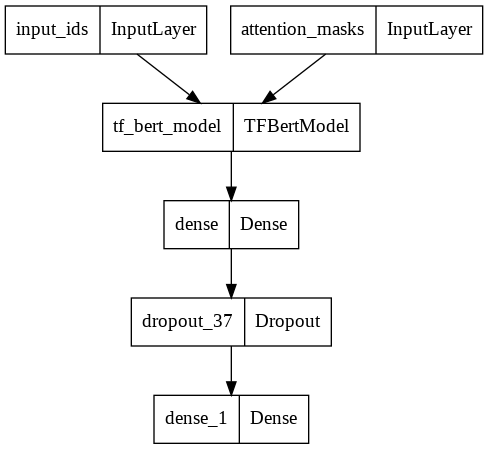

In [ ]:
tf.keras.utils.plot_model(modeltf)

In [ ]:
history = modeltf.fit(
    [train_input_ids, train_attention_masks],
    train_df['label'],
    validation_split=0.2, 
    epochs=3,
    batch_size=16)

Epoch 1/3
1262/1262 [==============================] - 1689s 1s/step - loss: 0.3760 - accuracy: 0.8295 - val_loss: 0.8936 - val_accuracy: 0.6511
Epoch 2/3
1262/1262 [==============================] - 1655s 1s/step - loss: 0.2456 - accuracy: 0.8977 - val_loss: 1.1903 - val_accuracy: 0.6400
Epoch 3/3
1262/1262 [==============================] - 1653s 1s/step - loss: 0.1712 - accuracy: 0.9328 - val_loss: 1.0200 - val_accuracy: 0.7373


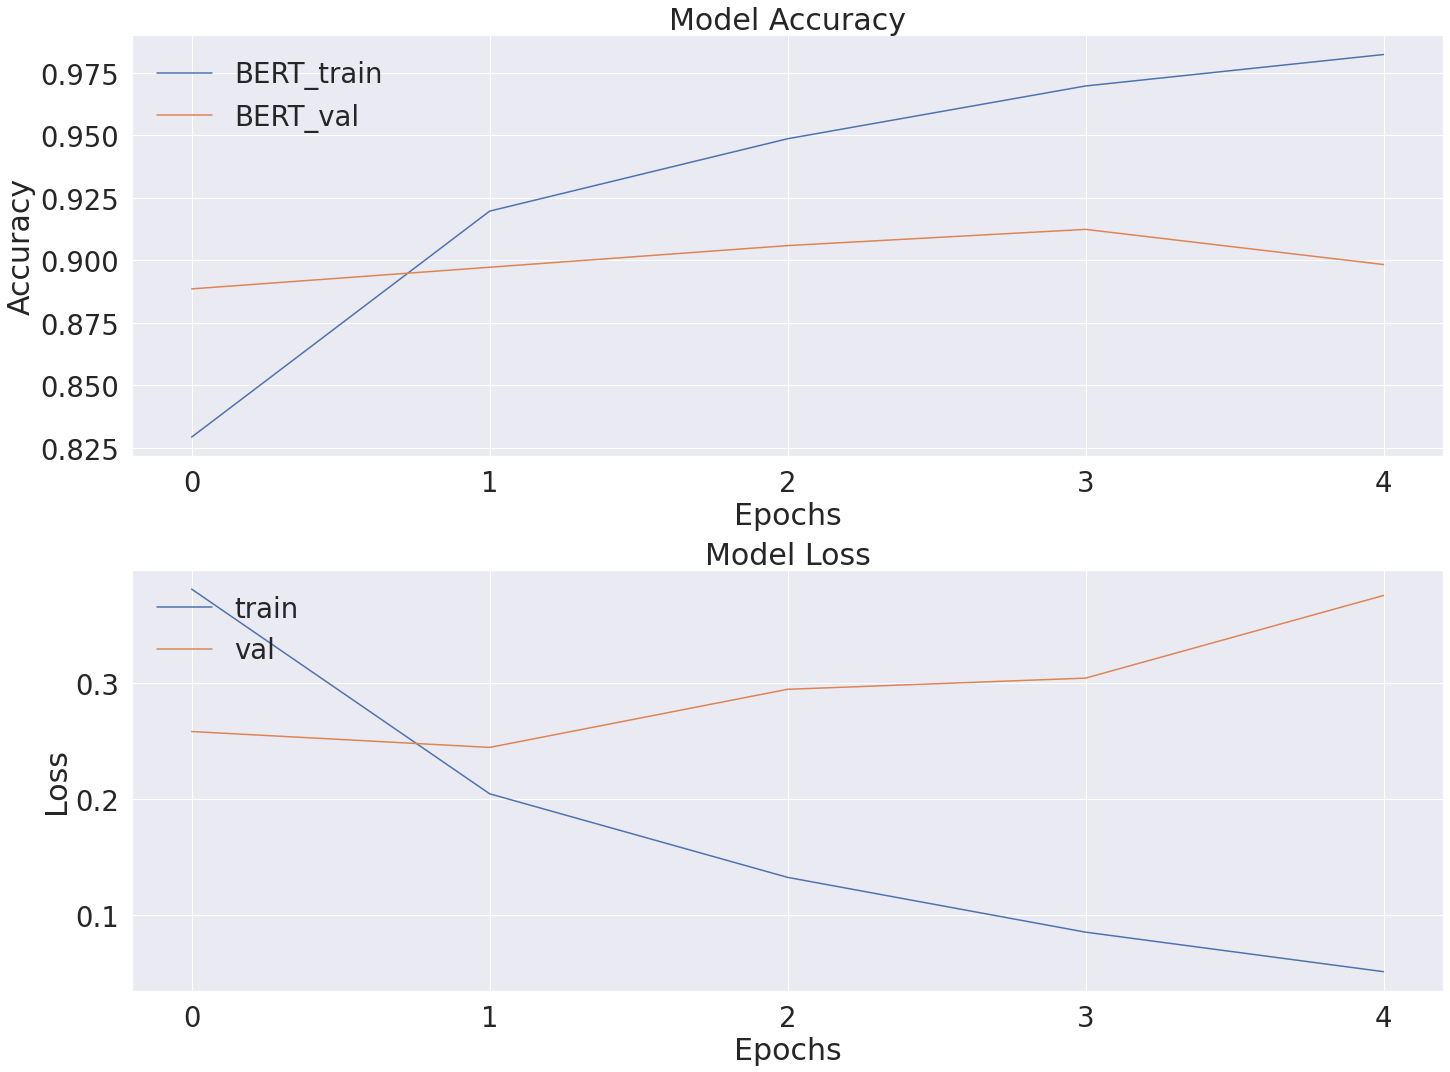

In [ ]:
f,ax = plt.subplots(2,1,figsize=(20,15))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_xticks([0,1,2,3,4])
ax[0].legend(['BERT_train', 'BERT_val'], loc='upper left')


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_xticks([0,1,2,3,4])
ax[1].legend(['train', 'val'], loc = 'upper left')

f.tight_layout()
plt.show()


# 모델 테스트

In [ ]:
from sklearn.metrics import accuracy_score

test_input_ids, test_attention_masks = bert_encode(train3_df['text'],352)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
loss, accuracy = loaded_model.evaluate([test_input_ids,test_attention_masks],train3_df['label'],batch_size= 128)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

# 버트로 문장 분류

In [ ]:
predicted = modeltf.predict([test_input_ids, test_attention_masks]) 

In [ ]:
output = pd.DataFrame({"text" : [], "label" : [], "predict" : []})

In [ ]:
for i in range(0,len(predicted)):
  newval = pd.DataFrame(data = [[test_text[i], (predicted[i] > 0.5).astype('int32')[0], predicted[i][0]]], columns = ['text', 'label', 'predict'])
  output = output.append(newval)

In [ ]:
attackword = output[output['label']==1.0]
display(attackword)

,text,label,predict
0,미국입장에서는 영웅아니노?,1.0,0.991711
3,배부른 미국 새끼들이라 그렇지 이제 문재앙같은 문 바이든새끼 집권했으니 쓴맛 좀 볼...,1.0,0.997776
4,저기없엇으면 개좆망이엿네 태평양쪽 막혀서 세계대전때 돈쓸어담기도 못햇을듯 미국의 영웅,1.0,0.879570
6,다크나이트였노ㅠㅠ,1.0,0.988686
7,그냥 궁금해서 그런데 만약 미국이 멕시코 먹었으면 남미도 창 안날수 있었음?,1.0,0.731896
...,...,...,...
79742,간지나는게 다 it 새로운산업인데 지혼자 보지허영심 이용해서 옷팔이 원시산업으로 세...,1.0,0.968262
79743,명품이 씹고부가가치 산업이지 ㄹㅇ 폰같은거는 일정가격 이상 올리면 안팔리는데 명품은...,1.0,0.989507
79748,미친새끼 ㅋㅋㅋㅋ,1.0,0.997444
79750,와 그러네 암드는 왜없노,1.0,0.985204


In [ ]:
attackword = attackword.reset_index(drop=True)
attackword.to_csv("/content/mnt/MyDrive/project/attackword.csv", mode='wt', encoding = 'utf-8-sig')

,text,label,predict
117,숨지마라 이블아이,0.0,0.132673
164,거른다 - dc App,0.0,0.124431
179,자기 직전 라면 5개 먹은 손나은,0.0,0.136167
371,알았어 아랐다구 윤석열로 기면 되잖아 그치?,0.0,0.166091
581,살만 하얬다면 지금도 잘나갈수있음?,0.0,0.138236
...,...,...,...
79680,리싸쑤 ㅇㄷ - dc App,0.0,0.123762
79704,봊이가 최고의 돈벌이 수단wwwwwwwwwwwwwwwwwwwwwwwwwwwwww,0.0,0.122899
79712,이게뭐냐 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 성공적인 봇질이었다네 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,0.0,0.145939
79717,222.232 < P,0.0,0.116602
